# DARPA MSIT Analysis Tutorial

## Step 1: Behavior Analysis
This section covers the behavioral analysis for MSIT. This section can only be run of the subject's behavioral file has been transferred to Lilli (/space/lilli/1/users/DARPA-Behavior/msit/csv).

### Step 1a: Preprocess and save MSIT data.

In [16]:
import os
import numpy as np
import pylab as plt
import pandas as pd
from pandas import read_csv
from scipy.io import savemat
from scipy.stats import probplot

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Define parameters.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
#SUBJ_LIST = pd.DataFrame.from_csv('$CSV_PATH')
    
SUBJ_LIST = ['hc001','hc002','hc003','hc004','hc005','hc006','hc007','hc008','hc009','hc010',\
             'hc011','hc012', 'hc013','hc014','hc015','hc016','hc017','hc018','hc019','hc020',\
             'hc021','hc022','hc023','hc024', 'hc025','hc026','hc028','hc029','hc030','hc031',\
             'hc032','hc033','hc034','hc035','hc036', 'hc037','hc038','hc042','hc044','hc045',\
             'pp001','pp002','pp003','pp004','pp005','pp006', 'pp007','pp008','pp009','pp010',\
             'pp011','pp012','pp013','pp014','pp015','pp016']

for SUBJ in SUBJ_LIST:
    
    ## I/O parameters.
    subject = '%s' % SUBJ

    ## Rejection parameters.
    missing = 0.10           # Threshold of fraction missing data for rejection.
    accuracy = 0.80          # Threshold of fraction accuracy data for rejection.
    fastRT = 0.3             # Threshold for reaction times, below which are censored.

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and preprocess data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load data.
    csv_dir = '/Users/emilyhahn/projects/msit/behavior'
    csv = read_csv(os.path.join(csv_dir, '%s_msit_mri.csv' %subject))
    csv = csv[csv.Condition!=0].reset_index(drop=True) # Remove rest trials.

    ## Update trial numbers.
    csv.Trial = np.arange(csv.shape[0]) + 1

    ## Set reaction times below fastRT threshold as missing.
    csv.ResponseAccuracy = np.where(csv.ResponseTime < fastRT, 99, csv.ResponseAccuracy)
    csv.ResponseTime = np.where(csv.ResponseTime < fastRT, np.nan, csv.ResponseTime)

    ## Set all 99s to NaNs in RTs.
    csv.ResponseTime = np.where(csv.ResponseTime==99, np.nan, csv.ResponseTime)
    csv.ResponseAccuracy = np.where(csv.ResponseAccuracy==99, np.nan, csv.ResponseAccuracy)
    csv['Missing'] = np.isnan(csv.ResponseTime).astype(int)

    ## Transform RTs. Add Intercept.
    csv['logRT'] = np.log(csv.ResponseTime)
    csv['Intercept'] = 1

    ## Reduce CSV to columns of interest.
    csv = csv[['Trial','Intercept','Condition','ResponseTime','logRT','ResponseAccuracy','Missing','StimOnset']]
    csv.columns = ['Trial','Intercept','Interference','RT','logRT','Accuracy','Missing','Onset']
    csv['Interference'] = np.where(csv['Interference']==2,1,0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Check quality. Save.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    if csv.RT.isnull().mean() > missing: 
        print 'Excluding %s: missing trials.' %subject
    elif csv.Accuracy.mean() < accuracy: 
        print 'Excluding %s: incorrect trials.' %subject
    else:
        mdict = dict()
        for col in csv.columns: mdict[col] = csv[col].as_matrix()
        savemat('/Users/emilyhahn/projects/msit/behavior_preproc/%s_msit_raw.mat' %subject, mdict)

    print 'Done.'

Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


### Step 1b: Run State Space Model

The MSIT state space model is as follows:

$$
RT(k) = \beta_0 + \beta_1 * Interference + X_{ss}(k)
$$
where
$$
X_{ss}(k) = X_{ss}(k - 1) + W
$$

Interference is 1 if the current trial k is an incongruent trial and 0 if it is a congruent trial.

Open Matlab and see the msit_sswrapper.m script.

### Step 1c: Visualize Results of State Space Model

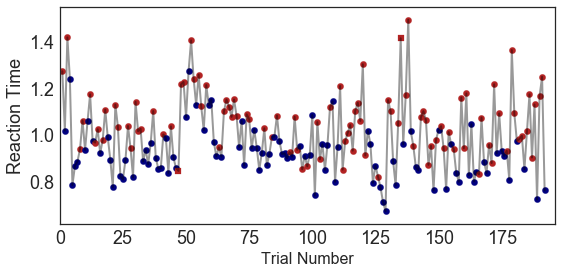

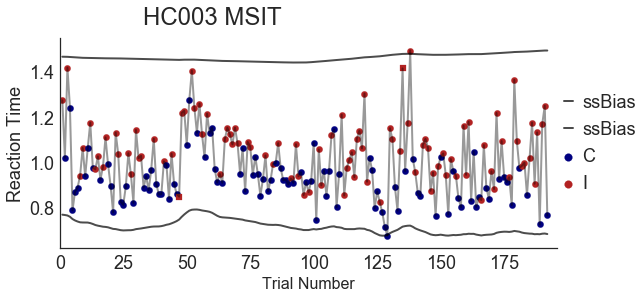

In [19]:
import os
import numpy as np
import pylab as plt
import seaborn as sns
from pandas import read_csv
from scipy.io import loadmat
import pandas as pd
sns.set_style('white')
sns.set_context('paper', font_scale=2.25)

#SUBJ_LIST = pd.DataFrame.from_csv('$CSV_PATH')    
 
# SUBJ_LIST = ['hc001','hc002','hc003','hc004','hc005','hc006','hc007','hc008','hc009','hc010',\
#              'hc011','hc012', 'hc013','hc014','hc015','hc016','hc017','hc018','hc019','hc020',\
#              'hc021','hc022','hc023','hc024', 'hc025','hc026','hc028','hc029','hc030','hc031',\
#              'hc032','hc033','hc034','hc035','hc036', 'hc037','hc038','hc042','hc044','hc045',\
#              'pp001','pp002','pp003','pp004','pp005','pp006', 'pp007','pp008','pp009','pp010',\
#              'pp011','pp012','pp013','pp014','pp015','pp016']

    
# SUBJ_LIST = ['pp005','pp014','hc001','hc007','hc013','hc022','hc024','hc029','hc035']

SUBJ_LIST = ['hc003']
    
for SUBJ in SUBJ_LIST:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Define parameters.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    subject = '%s' % SUBJ

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Main loop.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    def normalize(arr): return (arr - arr.min()) / (arr.max() - arr.min())
    behavior_dir = '/Users/emilyhahn/projects/msit/behavior/'

    fig = plt.figure(figsize=(12,4))
    mat = loadmat('/Users/emilyhahn/projects/msit/behavior_preproc/completed/%s_msit_ss.mat' % subject)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot MSIT RT barplot.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load and prepare behavior data.
    df = read_csv(os.path.join(behavior_dir,'%s_MSIT_MRI.csv' %subject))
    df = df[df.ResponseAccuracy!=99].reset_index(drop=True)
    df['zRT'] = (df.ResponseTime - df.ResponseTime.mean()) / df.ResponseTime.std()
    gb = df.groupby('Conflict').zRT.mean()

    ## Plot z-scored reaction times.
#     ax = plt.subplot2grid((1,4),(0,0))
#     ax.bar(range(len(gb)), gb, width=.8, color='gray')
#     ax.set_xlim(-0.5)
#     ax.set_xticks(np.arange(len(gb))+0.45)
#     ax.hlines(0,-0.5,len(gb))
#     ax.set_xticklabels(['CC','IC','CI','II'])
#     ax.set_ylabel('z-scored RT')
    
    
    ## Plot z-scored reaction times. *****NEW******
#     ax = plt.subplot2grid((1,4),(0,0))
#     colors = np.where(mat['Interference'].squeeze(), 'navy', 'firebrick')
#     ax.bar(range(1,3), [(gb[0]+gb[1])/2,(gb[2]+gb[3])/2], width=.9, color=colors)
#     ax.set_xticks([1,2])
#     ax.hlines(0,0,3)
#     ax.set_xticklabels(['C','I'])
#     ax.set_ylabel('z-scored RT')

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot timeseries of reaction times.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Initialize plot.
    ax = plt.subplot2grid((1,4),(0,1),colspan=3)    
    colors = np.where(mat['Interference'].squeeze(), 'firebrick', 'navy')
    markers = np.where(mat['Accuracy'],'o','s').squeeze()

    ## Plot lines/scatter points.
    rt = mat['RT'].squeeze()
    ax.plot(mat['Trial'].squeeze(), rt, color='k', linewidth=2, alpha=0.4)
    for x,y,c,m in zip(mat['Trial'].squeeze(), rt, colors, markers): 
        ax.scatter(x,y,s=40,marker=m,color=c)
    for color, label in zip(['navy', 'firebrick'], ['C','I']): 
        ax.scatter([],[], s=60, color=color, label=label)

    ## Add flourishes.
    ax.set_xlim(0,196)
    ax.set_xlabel('Trial Number', fontsize=16)
    ax.set_ylabel('Reaction Time', fontsize=18)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot state space regressor.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Assemble state space regressors.
    ss_outputs = np.expand_dims(np.array([np.concatenate(arr) for arr in mat['XSmt']]).squeeze(),1)

    ## Scale state space regressor.
    ss = normalize(ss_outputs.squeeze())
    ss *= np.nanmax(rt) - np.nanmin(rt)
    ss += np.nanmin(rt)

    ## Plot state-space.
#     ax.plot(mat['Trial'].squeeze(), ss.T, linewidth=2, color='k', label='ssBias', alpha=0.7)
# Integrate (xm-2*sqrt(xb) re: compass_plot_bound
    ax.plot(mat['Trial'].squeeze(), ss, linewidth=2, color='k', label='ssBias', alpha=0.7)
    
#     print ss

    ## Add flourishes.
    ax.legend(loc=7, bbox_to_anchor=(1.175,0.5), frameon=False, borderpad=0, handlelength=0.5, handletextpad=0.5)

    sns.despine()
    plt.suptitle('%s MSIT' %subject.upper(), y=0.99, fontsize=24)
    plt.subplots_adjust(left=0.1,right=0.9,bottom=0.15, wspace=0.75)
#     f = '/autofs/space/lilli_001/users/DARPA-Scripts/tutorials/darpa_msit_ecr_pipeline/plots/behavior/%s_msit_behavior.png' %subject
#     plt.savefig(f, dpi=160)
#     plt.close('all')
    plt.show()

#     print 'Done.'

## Step 2: Generate Task Regressors
This section creates the task regressors for the first level analysis of DARPA MSIT. The task regressor files will be saved for first-level analysis in the subject's FSFAST folder in: /autofs/space/lilli_004/users/DARPA-MSIT.

The ssBias (this is the state space term from the formulation above) was used for the H9.1 milestone analyses. The interference beta was used for the H9.3 milestone comparisons.

In [14]:
import os
import numpy as np
from scipy.io import loadmat
from scipy.special import gammaln

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

subject = 'hc007'
    
## Define contrasts.
conditions = ['Intercept','Interference','ssBias']
n_conditions = len(conditions)

## Timing information.
n_acq = 228
tr = 1.75
sfreq = 1e2

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define useful functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def spm_hrf(RT, P=None, fMRI_T=16):
    p = np.array([6, 16, 1, 1, 6, 0, 32], dtype=float)
    if P is not None:
        p[0:len(P)] = P

    _spm_Gpdf = lambda x, h, l: np.exp(h * np.log(l) + (h - 1) * np.log(x) - (l * x) - gammaln(h))
    # modelled hemodynamic response function - {mixture of Gammas}
    dt = RT / float(fMRI_T)
    u = np.arange(0, int(p[6] / dt + 1)) - p[5] / dt
    with np.errstate(divide='ignore'):  # Known division-by-zero
        hrf = _spm_Gpdf(u, p[0] / p[2], dt / p[2]) - _spm_Gpdf(u, p[1] / p[3],
                                                               dt / p[3]) / p[4]
    idx = np.arange(0, int((p[6] / RT) + 1)) * fMRI_T
    hrf = hrf[idx]
    hrf = hrf / np.sum(hrf)
    return hrf

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Initialize regressors.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 

## Setup timing information.
total_time = n_acq * tr
times = np.arange(0, total_time+1./sfreq, 1./sfreq)
n_times = times.shape[0]

## Initialize boxcars.
neural_signal = np.zeros((n_conditions,n_times))

## Extract information.
mat = loadmat('/autofs/space/lilli_001/users/DARPA-Scripts/tutorials/darpa_msit_ecr_pipeline_EH/behavior/%s_msit_ss.mat' %subject)
Interference = mat['Interference'].squeeze()
ssBias = np.concatenate(mat['XSmt'].squeeze()).squeeze()
TrialOnset = mat['Onset'].squeeze()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Generate boxcars.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 

for onset, i, ss in zip(TrialOnset,Interference,ssBias): 
    mask = (times >= onset) & (times <= onset + 1.75)
    neural_signal[0,mask] += 1         # Intercept
    neural_signal[1,mask] += i         # Interference
    neural_signal[2,mask] += ss        # State-space

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Generate fMRI regressors.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 

## Perform convolution.
hrf = spm_hrf(1./sfreq)
bold_signal = np.apply_along_axis(np.convolve, 1, neural_signal, v=hrf)
bold_signal = bold_signal[:,:neural_signal.shape[-1]] # Set back to original length.

## Downsample to start of TR.
tr_onsets = np.insert( np.cumsum( np.ones(n_acq-1)*tr ), 0, 0 )
ds = np.in1d(times, tr_onsets)
if not ds.sum() == n_acq: raise ValueError('Oh noes!')
bold_signal = bold_signal[:,ds]

## Normalize regressors. [See Calhoun et al. (2004)]
## First we normalize [Intercept, DDB, Valence] such that the sum
## of their timeseries squared is equal to 1.
sums = np.power(bold_signal,2).sum(axis=1)
bold_signal = (bold_signal.T / np.sqrt(sums)).T

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Save regressors.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 

out_dir = '/autofs/space/lilli_004/users/DARPA-MSIT/%s/msit_001/001' %subject
for arr, label in zip(bold_signal, conditions):

    f = '%s/msit_EH_V1.%s.par' %(out_dir,label)
    try: np.savetxt(f, arr[:,np.newaxis], fmt='%s')
    except IOError: pass

print 'Done.'

IOError: [Errno 2] No such file or directory: '/autofs/space/lilli_001/users/DARPA-Scripts/tutorials/darpa_msit_ecr_pipeline_EH/behavior/hc007_msit_ss.mat'

## Step 3: Generate Nuisance Regressors
This section creates custom nuisance regressors for use in the first-level analysis. Specifically, the script creates (1) demeaned, detrended, and orthogonalized motion regressors that explain 90% of the variance in the motion; and (2) the timepoints to censor based on functional displacement (FD; Power et al. 2012, 2014) values. Users will specify which FD thresholds to use to create subject-specific timepoint censoring files to be used in the first level analyses. 

In [ ]:
import os
import numpy as np
from pandas import read_csv
from scipy.signal import detrend
from sklearn.decomposition import PCA

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

subject = 'hc042'

## Define acquisition parameters.    
n_acq = 228
tr = 1.75

## Scrubbing parameters.
thresholds = [0.0, 0.5, 1.0, 1.5]
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute framewise displacement.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Read motion data.
out_dir = '/autofs/space/lilli_004/users/DARPA-MSIT/%s/msit_001/001' %subject
mc = os.path.join(out_dir, 'fmcpr.mcdat')
mc = np.loadtxt(mc)[:,1:7]

## Invert angular displacement.
fd = mc.copy()
fd[:,:3] = np.deg2rad(fd[:,:3]) 
fd[:,:3] *= 50

## Compute framewise displacement (See Power 2012, 2014).
fd = np.insert( np.abs( np.diff(fd, axis=0) ).sum(axis=1), 0, 0 )

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute motion regressors.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Remove trends.
mc = detrend(mc, axis=0, type='constant')
mc = detrend(mc, axis=0, type='linear')

## Perform PCA.
pca = PCA(n_components=6)
mc = pca.fit_transform(mc)

## Take only the number of components explaining 90% of the variance.
varexp = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(varexp >= 0.9) + 1
mc = mc[:,:n_components]

## Save motion regressor.
f = os.path.join(out_dir, 'msit_EH_V1.mc.par')
np.savetxt(f, mc, fmt='%s')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Write scrubbers.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define TR onsets.
tr_onsets = np.insert( np.cumsum( np.ones(n_acq - 1) * tr ), 0, 0 )

for threshold in thresholds:

    ## Find threshold violations.
    if not threshold: ix, = np.where(fd >= np.inf)
    else: ix, = np.where(fd >= threshold)

    ## Save.
    f = os.path.join(out_dir, 'msit_EH_V1.censor.%s.par' %threshold)
    if len(ix): np.savetxt(f, tr_onsets[ix,np.newaxis], fmt='%s')

print 'Done.'

## Step 4: Decide on Censor Level
This section will create a summary file for specified subjects and FD thresholds describing how many volumes (acquisitions) will be censored if the user chooses a specific FD threshold. The summary file is written to the fMRI folder.

In [ ]:
import os
from pandas import DataFrame, Series

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subjects.
subjects = ['hc042']

## Scrubbing parameters.
thresholds = [0.0, 0.5, 1.0, 1.5]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Make summary file.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

columns = ['Subject'] + ['FD=%s' %fd for fd in thresholds]
df = DataFrame([],columns=columns)

for subject in subjects:
    
    ## Initialize.
    info = Series()
    info['Subject'] = subject
    
    ## Iteratively lookup and store information.
    for fd in thresholds:
        f = '/autofs/space/lilli_004/users/DARPA-MSIT/%s/msit_001/001/msit_EH_V1.censor.%s.par' %(subject,fd)
        if os.path.isfile(f): info['FD=%s' %fd] = len(open(f,'r').readlines())
        else: info['FD=%s' %fd] = 0
            
    ## Append information.
    df = df.append(info, ignore_index=True)
    
## Save.
df.to_csv('fmri/msit_censor_summary.csv', index=False)
print 'Done.'

## Going forward . . .
##### The following changes need to be made:

<b>-------------------</b>

To-do: 
1. Run state-space model for all subs
2. Generate functional connectivity script
3. Compute FC for all subs (hc, pts)
4. Group level analysis? --osgm or --wls
5. Regress FC and state space results using model selection

<b>-------------------</b>

## Step 5: Run First-Level Scripts
To run the first levels, please see the scripts directory and follow the two steps:

1. Configure:    msit_mkanalysis_pm.csh
2. Run:          msit_selxavg3_pm.csh

## Step 6: Run Second-Level Scripts
To run the second levels, please see the scripts directory and follow the two steps:
1. Concatenate the subjects' data using msit_concatsess.
2. Compute the OSGM second levels using msit_glmfit.

## Step 7: Compute One vs. Many

### Step 7a: Compute One vs. Many Maps

In [ ]:
import os
import numpy as np
import nibabel as nib
from pandas import DataFrame
from mne import read_label, vertex_to_mni
from nibabel.affines import apply_affine
mri_dir = '/autofs/space/lilli_004/users/DARPA-MSIT/'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define one vs. many groups.
controls = ['hc001','hc002','hc004','hc005']
comparators = ['pp001']

## Define I/O parameters.
analysis = 'FINAL.6.0.0.rh'
contrast = 'FINAL.Interference.par'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute control mean and standard deviation.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load control data.
control_maps = []
for con in controls: 
    control_maps.append( nib.load(os.path.join(mri_dir,con,'msit_001',analysis,contrast,'ces.nii.gz')).get_data() )
    
## Compute mean and standard deviation.
mean = np.mean(control_maps, axis=0)
std = np.std(control_maps, axis=0)
del control_maps

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Iteratively compute one-vs-many maps.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for comp in comparators:

    ## Load data.
    obj = nib.load(os.path.join(mri_dir,con,'msit_001',analysis,contrast,'ces.nii.gz'))
    arr = obj.get_data()
    affine = obj.affine
    
    ## Compute OVM.
    with np.errstate(divide='ignore', invalid='ignore'):
        ovm = np.true_divide( arr - mean, std )
        ovm[ ~np.isfinite( ovm )] = 0 

    ## Save.
    obj = nib.Nifti1Image(ovm, affine)
    nib.save(obj, os.path.join('fmri','ovm','%s_msit_ovm_%s.nii.gz' %(comp,analysis.split('.')[-1])))
    
print 'Done.'

### Step 7b: Extract One vs. Many Signal from Labels

In [ ]:
import os
import numpy as np
import nibabel as nib
from pandas import DataFrame
from mne import read_label, vertex_to_mni
from nibabel.affines import apply_affine

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

subject = 'pp001'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Extract information per label.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
fs_dir = '/space/lilli/1/users/DARPA-Recons'
label_dir = 'fmri/labels/'
info = []

for hemi in ['lh','rh','mni305']:

    ## Load data.
    obj = nib.load('fmri/ovm/%s_msit_ovm_%s.nii.gz' %(subject,hemi))
    ovm = obj.get_data().squeeze()
    affine = obj.affine
    
    if hemi == 'mni305':

        ## Locate labels.
        labels = [f for f in os.listdir(label_dir) if f.endswith('nii.gz')]

        ## Iterate over labels.
        for label in labels:

            ## Define ROI.
            roi = label.split('.')[0]

            ## Load mask and apply to OVM map.    
            mask = nib.load(os.path.join(label_dir,label)).get_data().squeeze()
            mask = ovm.copy() * mask

            ## Identify max voxel. Identify MNI coordinates.
            vertex = np.argmax(np.abs(mask))
            ix = np.concatenate(np.where(np.abs(mask).max() == np.abs(mask)))
            x,y,z = apply_affine(affine, ix)

            ## Compute summary statistics.
            mean_voxel = np.median(mask[mask.nonzero()])
            max_voxel = mask[ix[0],ix[1],ix[2]]

            ## Store.
            info.append([roi,mean_voxel,max_voxel,vertex,x,y,z])

    else:

        ## Locate labels
        labels = [f for f in os.listdir(label_dir) if f.endswith('%s.label' %hemi)]

        ## Iterate over labels.
        for label in labels:

            ## Define ROI.
            roi = label.split('.')[0]

            ## Load label, create mask, and apply to OVM map.    
            mask = read_label(os.path.join(label_dir,label))
            mask = np.in1d(np.arange(len(ovm)), mask.vertices).astype(int)
            mask = ovm.copy() * mask

            ## Identify max voxel. Identify MNI coordinates.
            vertex = np.argmax(np.abs(mask))
            x,y,z = np.round(vertex_to_mni(vertex, 0 if hemi=='lh' else 1, 'fsaverage', 
                                           fs_dir, verbose=False)[0])

            ## Compute summary statistics.
            mean_voxel = np.median(mask[mask.nonzero()])
            max_voxel = mask[vertex]

            ## Store.
            info.append([roi,mean_voxel,max_voxel,vertex,x,y,z])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Consolidate and save anatomical information.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

info = DataFrame(np.array(info), columns=('ROI','Mean','Max','Vertex','X','Y','Z'))
info = info.sort_values('ROI').reset_index(drop=True)
info.to_csv('fmri/%s_msit_ovm_results.csv' %subject, index=False)

print 'Done.'

## Step 8: Construct Partial Correlation Matrices

### Step 8a: Extract Timeseries

In [ ]:
import os
import numpy as np
import nibabel as nib
from pandas import DataFrame
from mne import read_label

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

subject = 'pp002_mb'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Iteratively perform one-vs-many.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

base = '/space/lilli/2/users/DARPA-MSIT/%s/msit_001/001/fmcpr.sm6.%s.b0dc.nii.gz'
label_dir = 'fmri/labels'
out_dir = 'fmri/extractions'
    
for hemi in ['lh','rh','mni305']:

    if hemi == 'mni305':

        ## Load timeseries (try/catch to hande if files are saved as .nii).
        try: 
            f = base %(subject, 'mni305.2mm')
            ts = nib.load(f).get_data()
        except: 
            f = base[:-3] %(subject, 'mni305.2mm')
            ts = nib.load(f).get_data()

        ## Locate labels.
        labels = [f for f in os.listdir(label_dir) if f.endswith('nii.gz')]

        ## Iteratively extract and save.
        for label in labels:
            roi = label.split('.')[0]
            label = nib.load(os.path.join(label_dir,label)).get_data()
            label = (label.T * ts.T).T
            label = np.where(label,label,np.nan)
            label = np.apply_over_axes(np.nanmean, label, [0,1,2]).squeeze()
            np.save(os.path.join(out_dir, '%s_msit_%s' %(subject,roi)), label)

    else:

        ## Load timeseries (try/catch to hande if files are saved as .nii).
        try:
            f = base %(subject, 'fsaverage.%s' %hemi)
            ts = nib.load(f).get_data()
        except:
            f = base[:-3] %(subject, 'fsaverage.%s' %hemi)
            ts = nib.load(f).get_data()

        ## Locate labels
        labels = [f for f in os.listdir(label_dir) if f.endswith('%s.label' %hemi)]

        ## Iteratively extract and save.
        for label in labels:
            roi = label.split('.')[0]
            label = read_label(os.path.join(label_dir,label))
            label = ts[label.vertices].mean(axis=0).squeeze()
            np.save(os.path.join(out_dir, '%s_msit_%s' %(subject,roi)), label)
            
print 'Done.'

### Step 8b: Compute and Visualize Network

In [ ]:
import os
import numpy as np
import networkx as nx
import pylab as plt
import seaborn as sns
from itertools import combinations
sns.set_style('white')
sns.set_context('paper', font_scale=2.)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

subject = 'pp001'
rois = ['Caudate', 'Hippocampus', 'NAcc', 'Insula', 'DLPFC', 'DMPFC', 'dACC', 'STN']
hemi = 'lh'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def zscore(arr): return (arr - arr.mean()) / arr.std()

def partial_correlation(cov):
    prec = np.linalg.inv(cov)
    i,j = np.tril_indices_from(cov,k=-1)
    return np.array([ -prec[i,j] / np.sqrt(prec[i,i]*prec[j,j]) ]) 
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = []
for roi in rois: data.append(np.load('fmri/extractions/%s_msit_%s-%s.npy' %(subject,roi.lower(),hemi)))
data = np.array(data) 

## Prepare data.
data = np.apply_along_axis(zscore, 1, data)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Construct partial correlation network.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute covariance matrix.
cov = np.cov(data)

## Extract off-diagonal elements.
pcorr = partial_correlation(cov).squeeze()

## Define edges.
edges = list(combinations(rois, 2))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Visualize network.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize network.
G = nx.Graph()
G.add_nodes_from(rois)

## Add edges.
for dyad, weight in zip(edges, pcorr):
    G.add_edge(dyad[0], dyad[1], weight=weight)

## Plotting.
fig, ax = plt.subplots(1,1,figsize=(6,6))
pos = nx.circular_layout(G, scale=3)

## Draw network.
nx.draw_networkx_nodes(G,pos,node_size=2.5e3,node_shape='o',alpha=1,node_color=colors[0])
nx.draw_networkx_labels(G,pos,font_size=16)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='grey', width=1)

labels = dict()
for g in G.edges_iter(data='weight'): labels[g[:2]] = np.round(g[-1],2)
nx.draw_networkx_edge_labels(G,pos,edge_labels=dict((k, v) for k, v in labels.items() if v >= .25),
                             label_pos=0.4,font_size=14, font_weight='bold')
nx.draw_networkx_edge_labels(G,pos,edge_labels=dict((k, v) for k, v in labels.items() if v < .25),
                             label_pos=0.4,font_size=10, font_weight='normal')

## Draw weights.
#     deg_cent = nx.degree_centrality(G)  
#     for n,v in deg_cent.items():
#         plt.text(x=pos[n][0],y=pos[n][1]-.4,s='%0.2f' %v, fontsize=14, ha='center')

## Clean up.
ax.axis('off')
ax.set_title('MSIT')
    
plt.tight_layout()
# plt.show()
plt.savefig('plots/networks/%s_msit_network-%s.png' %(subject,hemi), dpi=180)
plt.close('all')
print 'Done.'